In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

face-expression-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref= zipfile.ZipFile('/content/face-expression-recognition-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

# Displaying Images

In [6]:
picture_size = 48
folder_path = "/content/images"

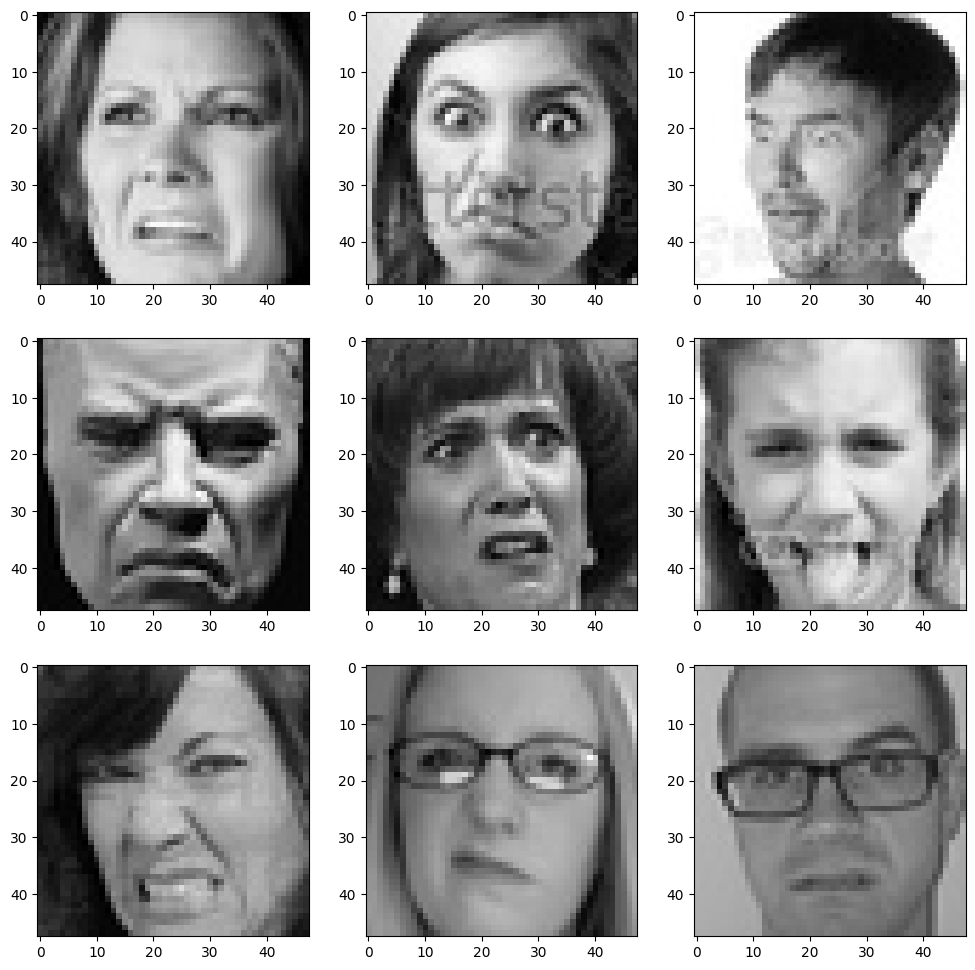

In [7]:
expression = 'disgust'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"/train/"+expression+"/"+
                  os.listdir(folder_path + "/train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

# Making Training and Validation Data

In [8]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"/train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"/validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [9]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#5th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 3rd layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 4th layer
model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

# Fitting the Model with Training and Validation Data

In [10]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [14]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/48


<ipython-input-14-981791b505f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


225/225 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.6376

225/225 [==============================] - 18s 80ms/step - loss: 0.9703 - accuracy: 0.6376 - val_loss: 1.0188 - val_accuracy: 0.6223 - lr: 2.0000e-04
Epoch 2/48
225/225 [==============================] - ETA: 0s - loss: 0.9224 - accuracy: 0.6546

225/225 [==============================] - 18s 79ms/step - loss: 0.9224 - accuracy: 0.6546 - val_loss: 1.0537 - val_accuracy: 0.6189 - lr: 2.0000e-04
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 0.9116 - accuracy: 0.6635

225/225 [==============================] - 18s 81ms/step - loss: 0.9116 - accuracy: 0.6635 - val_loss: 1.0379 - val_accuracy: 0.6230 - lr: 2.0000e-04
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 0.8823 - accuracy: 0.6722Restoring model weights from the end of the best epoch: 1.



Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
225/225 [==============================] - 18s 80ms/step - loss: 0.8823 - accuracy: 0.6722 - val_loss: 1.0491 - val_accuracy: 0.6107 - lr: 2.0000e-04
Epoch 4: early stopping


# Plotting Accuracy & Loss

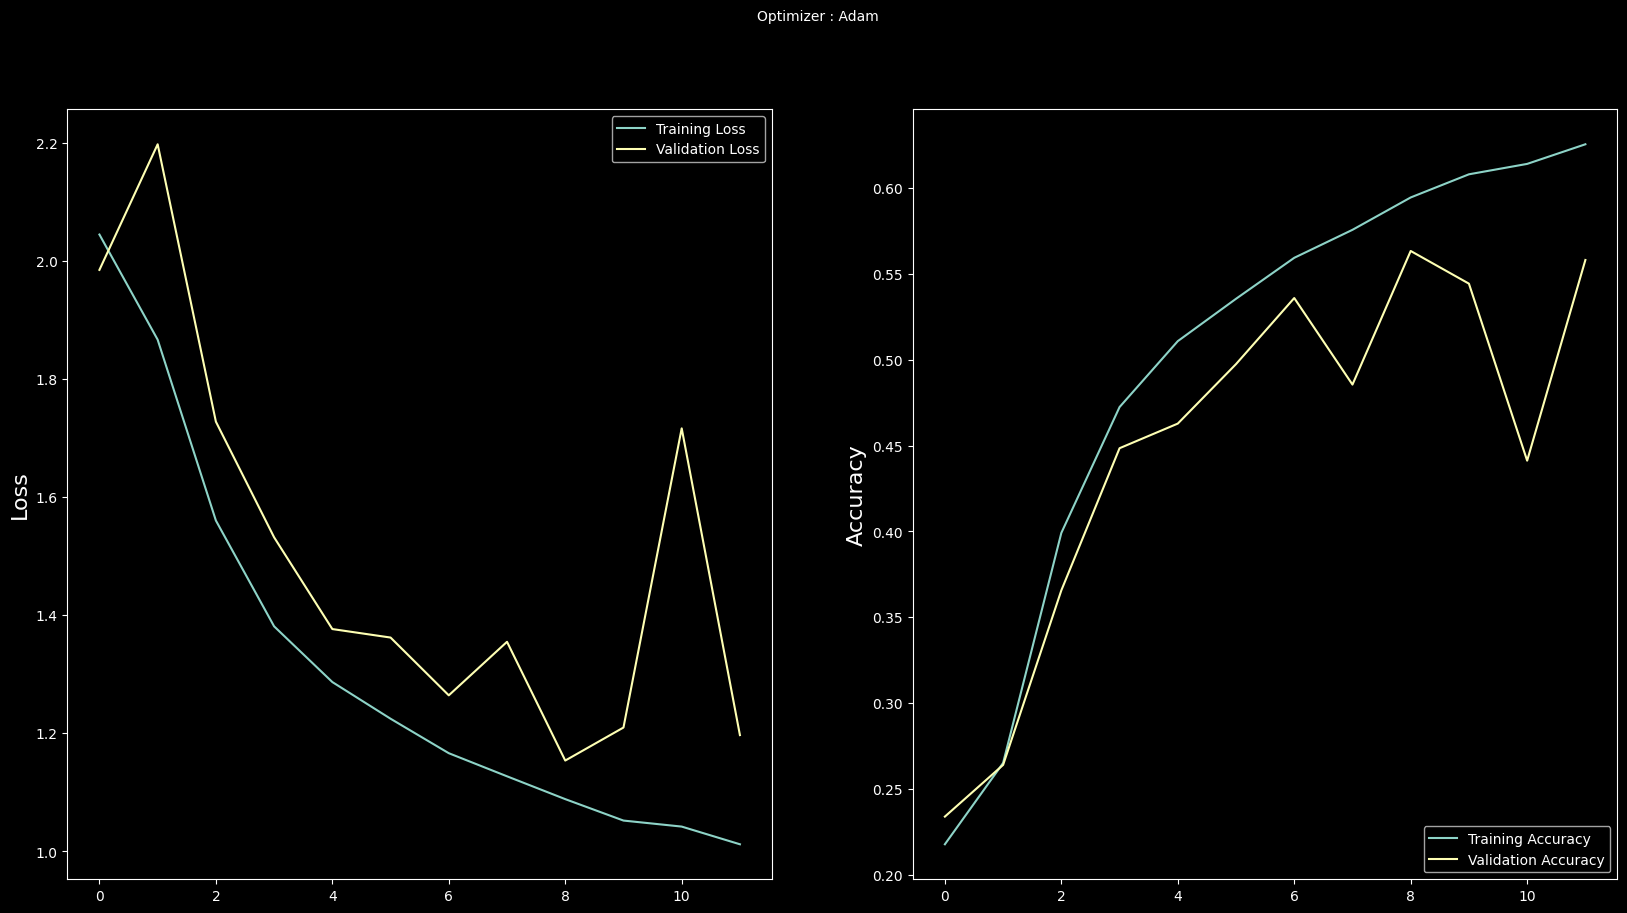

In [12]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [13]:
from tensorflow.keras.models import load_model, save_model


model.save('emotion.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
